In [ ]:
!pip install xarray tensorflow netCDF4 xgboost lightgbm

import pandas as pd
import numpy as np
import xarray as xr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 190.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 135.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 144.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 151.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 k

In [ ]:
import pandas as pd

flights_meta = '/content/drive/MyDrive/Flight_Datas/Flights_20220601_20220630.csv'
df_meta = pd.read_csv(flights_meta)
allowed_segments = ['All-Cargo', 'Mainline', 'Lowcost', 'Charter', 'Regional Aircraft']
df_meta = df_meta[df_meta['STATFOR Market Segment'].isin(allowed_segments)].copy()
df_meta_1000 = df_meta.head(30000)
allowed_ids = set(df_meta_1000['ECTRL ID'])


In [ ]:
filed_csv  = "/content/drive/MyDrive/Flight_Datas/Flight_Points_Filed_20220601_20220630.csv"
actual_csv = "/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv"

df_filed = pd.read_csv(filed_csv)
df_actual = pd.read_csv(actual_csv)

# Sadece allowed_id’lere ait satırlar
df_filed = df_filed[df_filed['ECTRL ID'].isin(allowed_ids)].copy()
df_actual = df_actual[df_actual['ECTRL ID'].isin(allowed_ids)].copy()


NameError: name 'allowed_ids' is not defined

In [ ]:
for df_ in [df_filed, df_actual]:
    df_.sort_values(["ECTRL ID", "Time Over"], inplace=True)
    df_["CloudBase_m"] = (
        df_.groupby("ECTRL ID")["CloudBase_m"]
           .apply(lambda s: s.ffill().bfill())
           .reset_index(level=0, drop=True)
    )
    df_["CloudBase_m"].fillna(0, inplace=True)


<ipython-input-4-1145033546>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_["CloudBase_m"].fillna(0, inplace=True)
<ipython-input-4-1145033546>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method

Optimizasyon

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time

# --- Candidate Generation ---
def generate_candidates(waypoints, n_per_point=5, delta_deg=0.05):
    """
    Her filed waypoint etrafında n_per_point adet, ±delta_deg derecelik
    rastgele ofsetli candidate nokta üretir.
    """
    candidates = []
    waypoints = waypoints.reset_index(drop=True)
    for i, wp in waypoints.iterrows():
        lat, lon, fl = wp['Latitude'], wp['Longitude'], wp['Flight Level']
        # Başlangıç ve bitiş noktaları
        if i == 0 or i == len(waypoints) - 1:
            candidates.append([lat, lon, fl])
        else:
            # Orijinal waypoint
            candidates.append([lat, lon, fl])
            # Çevresinde candidate'ler
            for _ in range(n_per_point):
                new_lat = lat + np.random.uniform(-delta_deg, delta_deg)
                new_lon = lon + np.random.uniform(-delta_deg, delta_deg)
                candidates.append([new_lat, new_lon, fl])
    return pd.DataFrame(candidates, columns=['Latitude', 'Longitude', 'Flight Level'])

# --- Haversine ---
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371e3  # metre
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# --- Graph Optimizasyon: sadece fuel cost ---
def build_graph(candidates, fuel_model):
    """
    Her bir candidate çifti arasındaki fuel maliyetine göre yönlendirilmiş graf oluşturur.
    """
    G = nx.DiGraph()
    n = len(candidates)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            node1 = candidates.iloc[i]
            node2 = candidates.iloc[j]
            cost = fuel_model.estimate(node1, node2)
            G.add_edge(i, j, weight=cost)
    return G

# --- En iyi yolu bul ---
def find_best_path(G, start, end):
    return nx.dijkstra_path(G, start, end, weight='weight')

# --- Toplam mesafe hesaplama ---
def compute_total_distances(df):
    totals = {}
    for fid, grp in df.groupby('ECTRL ID'):
        pts = grp.sort_values('Time Over')[['Latitude','Longitude']].values
        dist_sum = sum(
            haversine_np(lat1, lon1, lat2, lon2)
            for (lat1, lon1), (lat2, lon2) in zip(pts[:-1], pts[1:])
        )
        totals[fid] = dist_sum
    return pd.Series(totals)

# --- Basit fuel model ---
class DummyFuelModel:
    def __init__(self, cost_per_meter=0.001):
        self.cost_per_meter = cost_per_meter
    def estimate(self, node1, node2):
        dist = haversine_np(
            node1['Latitude'], node1['Longitude'],
            node2['Latitude'], node2['Longitude']
        )
        return dist * self.cost_per_meter

fuel_model = DummyFuelModel()

# --- Ana Pipeline: sadece optimizasyon ---
def main():
    # Veri yükle
    df_filed = pd.read_csv('/content/drive/MyDrive/Flight_Datas/Flight_Points_Filed_20220601_20220630.csv')
    df_actual = pd.read_csv('/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv')

    # Sadece ilk 100 uçuş
    flight_ids = df_filed['ECTRL ID'].unique()[:100]
    df_filed = df_filed[df_filed['ECTRL ID'].isin(flight_ids)].copy()
    df_actual = df_actual[df_actual['ECTRL ID'].isin(flight_ids)].copy()

    # Gerçek mesafeleri hesapla
    actual_dists = compute_total_distances(df_actual)

    results = []
    start_all = time.time()

    for fid in tqdm(flight_ids, desc="Optimizing flights", unit="flight"):
        wpts = df_filed[df_filed['ECTRL ID'] == fid][['Latitude','Longitude','Flight Level']]
        if len(wpts) < 2:
            continue

        # Candidate üret
        cand = generate_candidates(wpts, n_per_point=5, delta_deg=0.05)
        # Graph oluştur
        G = build_graph(cand, fuel_model)
        # Optimum yol
        path = find_best_path(G, 0, len(cand)-1)

        # Optimize edilen mesafe
        opt_dist = sum(
            haversine_np(
                cand.iloc[i]['Latitude'], cand.iloc[i]['Longitude'],
                cand.iloc[j]['Latitude'], cand.iloc[j]['Longitude']
            ) for i, j in zip(path[:-1], path[1:])
        )

        actual_dist = actual_dists.get(fid, np.nan)
        improvement = (actual_dist - opt_dist) / actual_dist * 100 if actual_dist else np.nan

        results.append({
            'ECTRL ID': fid,
            'actual_dist_m': actual_dist,
            'optimized_dist_m': opt_dist,
            'improvement_pct': improvement
        })

    print(f"Total optimization time: {time.time() - start_all:.2f} s")
    print(pd.DataFrame(results))

if __name__ == '__main__':


Optimizing flights: 100%|██████████| 100/100 [07:19<00:00,  4.39s/flight]

Total optimization time: 439.38 s
     ECTRL ID  actual_dist_m  optimized_dist_m  improvement_pct
0   252119478   5.564869e+05      5.279186e+05         5.133691
1   252119479   6.398492e+06      6.181053e+06         3.398281
2   252119481   5.556307e+06      5.292121e+06         4.754701
3   252119482   7.811279e+06      7.626377e+06         2.367109
4   252119483   1.065172e+06      1.026495e+06         3.631015
..        ...            ...               ...              ...
95  252119578   1.008790e+06      9.590899e+05         4.926713
96  252119579   1.880385e+06      1.765858e+06         6.090588
97  252119580   3.281917e+05      2.807557e+05        14.453741
98  252119581   2.405049e+06      2.302640e+06         4.258077
99  252119582   9.597222e+06      9.437607e+06         1.663140

[100 rows x 4 columns]


Yeni Deneme(Hava durumu ile birlikte)

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import xarray as xr
from tqdm import tqdm
import time

# --- Candidate Generation ---
def generate_candidates(waypoints, n_per_point=5, delta_deg=0.05):
    """
    Her planned waypoint için çevresinde n_per_point adet ±delta_deg ofsetli candidate üretir,
    ve her candidate'a orijinal 'Time Over' bilgisini ekler.
    waypoints: DataFrame sütunlarında ['Latitude','Longitude','Flight Level','Time Over']
    """
    candidates = []
    waypoints = waypoints.reset_index(drop=True)
    for i, wp in waypoints.iterrows():
        lat, lon, fl, t = (
            wp['Latitude'], wp['Longitude'],
            wp['Flight Level'], wp['Time Over']
        )
        # Başlangıç veya bitiş noktası
        if i == 0 or i == len(waypoints) - 1:
            candidates.append([lat, lon, fl, t])
        else:
            # Orijinal waypoint
            candidates.append([lat, lon, fl, t])
            # Çevresindeki random candidate'ler
            for _ in range(n_per_point):
                new_lat = lat + np.random.uniform(-delta_deg, delta_deg)
                new_lon = lon + np.random.uniform(-delta_deg, delta_deg)
                candidates.append([new_lat, new_lon, fl, t])
    return pd.DataFrame(candidates, columns=['Latitude','Longitude','Flight Level','Time Over'])

# --- Haversine ---
def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371e3  # metre
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# --- Weather-aware Fuel Model ---
class WeatherFuelModel:
    def __init__(self, ds, cost_per_meter=0.001, wind_coeff=0.0001):
        """ds: xarray.Dataset içinde wind bileşenleri 'u10','v10' ve coordinate 'valid_time'"""
        self.ds = ds
        self.cost_per_meter = cost_per_meter
        self.wind_coeff = wind_coeff

    def estimate(self, node1, node2):
        # Base distance cost
        dist = haversine_np(
            node1['Latitude'], node1['Longitude'],
            node2['Latitude'], node2['Longitude']
        )
        # Zamanı datetime64'a çevir
        t64 = np.datetime64(pd.to_datetime(node1['Time Over']))
        lat = node1['Latitude']
        lon = node1['Longitude']
        # U/V wind bileşenlerini 'u10' ve 'v10' koordinatından al
        u = self.ds['u10'].sel(
            valid_time=t64, latitude=lat, longitude=lon,
            method='nearest'
        ).values.item()
        v = self.ds['v10'].sel(
            valid_time=t64, latitude=lat, longitude=lon,
            method='nearest'
        ).values.item()
        # Rota vektörü
        dx = node2['Longitude'] - node1['Longitude']
        dy = node2['Latitude'] - node1['Latitude']
        norm = np.hypot(dx, dy)
        headwind = 0.0
        if norm > 0:
            headwind = -(u * dx + v * dy) / norm
        # Wind penalty ekle
        wind_pen = self.wind_coeff * headwind
        return dist * self.cost_per_meter + wind_pen

# --- Graph Optimizasyon: fuel + wind ---
def build_graph(candidates, fuel_model):
    G = nx.DiGraph()
    n = len(candidates)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            cost = fuel_model.estimate(candidates.iloc[i], candidates.iloc[j])
            G.add_edge(i, j, weight=cost)
    return G

# --- En iyi yolu bul ---
def find_best_path(G, start, end):
    return nx.dijkstra_path(G, start, end, weight='weight')

# --- Toplam mesafe hesaplama ---
def compute_total_distances(df):
    totals = {}
    for fid, grp in df.groupby('ECTRL ID'):
        pts = grp.sort_values('Time Over')[['Latitude','Longitude']].values
        dist_sum = sum(
            haversine_np(lat1, lon1, lat2, lon2)
            for (lat1, lon1), (lat2, lon2) in zip(pts[:-1], pts[1:])
        )
        totals[fid] = dist_sum
    return pd.Series(totals)

# --- Pipeline ---
def main():
    # 1) Veri yükle
    df_filed = pd.read_csv(
        '/content/drive/MyDrive/Flight_Datas/Flight_Points_Filed_20220601_20220630.csv'
    )
    df_actual = pd.read_csv(
        '/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv'
    )
    nc_path = '/content/drive/MyDrive/Flight_Datas/data_stream-oper_stepType-instant.nc'
    ds = xr.open_dataset(nc_path)

    # 2) İlk 100 uçuş seç
    flight_ids = df_filed['ECTRL ID'].unique()[:100]
    df_filed = df_filed[df_filed['ECTRL ID'].isin(flight_ids)].copy()
    df_actual = df_actual[df_actual['ECTRL ID'].isin(flight_ids)].copy()

    # 3) Gerçek mesafeleri hesapla
    actual_dists = compute_total_distances(df_actual)

    # 4) WeatherFuelModel örneği
    fuel_model = WeatherFuelModel(ds)

    results = []
    start_all = time.time()
    for fid in tqdm(flight_ids, desc="Optimizing flights", unit="flight"):
        wpts = df_filed[df_filed['ECTRL ID'] == fid][[
            'Latitude','Longitude','Flight Level','Time Over'
        ]]
        if len(wpts) < 2:
            continue

        # 5) Candidate üret
        cand = generate_candidates(wpts, n_per_point=5, delta_deg=0.05)
        # 6) Graph oluştur ve en iyi yol
        G = build_graph(cand, fuel_model)
        path = find_best_path(G, 0, len(cand) - 1)

        # 7) Optimize mesafe hesapla
        opt_dist = sum(
            haversine_np(
                cand.iloc[i]['Latitude'], cand.iloc[i]['Longitude'],
                cand.iloc[j]['Latitude'], cand.iloc[j]['Longitude']
            ) for i, j in zip(path[:-1], path[1:])
        )

        actual_dist = actual_dists.get(fid, np.nan)
        improvement = (actual_dist - opt_dist) / actual_dist * 100 if actual_dist else np.nan
        results.append({
            'ECTRL ID': fid,
            'actual_dist_m': actual_dist,
            'optimized_dist_m': opt_dist,
            'improvement_pct': improvement
        })
    print(f"Total optimization time: {time.time() - start_all:.2f} s")
    print(pd.DataFrame(results))

if __name__ == '__main__':
    main()


Optimizing flights: 100%|██████████| 100/100 [9:18:09<00:00, 334.90s/flight]


Total optimization time: 33489.85 s
     ECTRL ID  actual_dist_m  optimized_dist_m  improvement_pct
0   252119478   5.564869e+05      5.279186e+05         5.133684
1   252119479   6.398492e+06      6.181053e+06         3.398281
2   252119481   5.556307e+06      5.292121e+06         4.754701
3   252119482   7.811279e+06      7.626377e+06         2.367109
4   252119483   1.065172e+06      1.026495e+06         3.631015
..        ...            ...               ...              ...
95  252119578   1.008790e+06      9.590899e+05         4.926713
96  252119579   1.880385e+06      1.765858e+06         6.090588
97  252119580   3.281917e+05      2.807557e+05        14.453741
98  252119581   2.405049e+06      2.302640e+06         4.258077
99  252119582   9.597222e+06      9.437607e+06         1.663139

[100 rows x 4 columns]


In [ ]:
def compute_total_distances(df):
    totals = {}
    for fid, grp in df.groupby('ECTRL ID'):
        pts = grp.sort_values('Time Over')[['Latitude','Longitude']].values
        dist_sum = sum(
            haversine_np(lat1, lon1, lat2, lon2)
            for (lat1, lon1), (lat2, lon2) in zip(pts[:-1], pts[1:])
        )
        totals[fid] = dist_sum
    return pd.Series(totals)

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371e3  # metre
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [ ]:
# Filed mesafeleri (metre)

nc_path    = "/content/drive/MyDrive/Flight_Datas/data_stream-oper_stepType-instant.nc"
flights_meta = '/content/drive/MyDrive/Flight_Datas/Flights_20220601_20220630.csv'
df_meta   = pd.read_csv(flights_meta)

filed_dists = compute_total_distances(df_filed)

# Actual mesafeleri (metre)
actual_dists = compute_total_distances(df_actual)
# df_meta’ya yeni sütunlar yaratıyoruz
df_meta['filed_dist_m']  = df_meta['ECTRL ID'].map(filed_dists)
df_meta['actual_dist_m'] = df_meta['ECTRL ID'].map(actual_dists)

# Sapma: actual – filed
df_meta['sapma_m']       = df_meta['actual_dist_m'] - df_meta['filed_dist_m']
filed_dists  = compute_total_distances(df_filed)
actual_dists = compute_total_distances(df_actual)

# 2. df_meta’ya ekle
df_meta['filed_dist_m']  = df_meta['ECTRL ID'].map(filed_dists)
df_meta['actual_dist_m'] = df_meta['ECTRL ID'].map(actual_dists)
df_meta['sapma_m']       = df_meta['actual_dist_m'] - df_meta['filed_dist_m']

# 3. Sonucu incele
print(df_meta.head())

    ECTRL ID  ADEP  ADEP Latitude  ADEP Longitude  ADES  ADES Latitude  \
0  252119478  EGSS       51.88500         0.23500  EGAA       54.65750   
1  252121322  KTEB       40.85000       -74.06667  LIPZ       45.50528   
2  252121323  ZSPD       31.13333       121.78333  EGLL       51.47750   
3  252123177  LEMD       40.47222        -3.56083  LEPA       39.55167   
4  252123178  VOHS       17.25000        78.41667  EGLL       51.47750   

   ADES Longitude FILED OFF BLOCK TIME   FILED ARRIVAL TIME  \
0        -6.21583  01-06-2022 00:00:00  01-06-2022 01:07:44   
1        12.35194  01-06-2022 00:00:00  01-06-2022 08:06:14   
2        -0.46139  01-06-2022 00:00:00  01-06-2022 12:17:48   
3         2.73889  01-06-2022 00:00:00  01-06-2022 01:51:57   
4        -0.46139  01-06-2022 00:00:00  01-06-2022 09:38:12   

  ACTUAL OFF BLOCK TIME  ... AC Type AC Operator AC Registration  \
0   31-05-2022 23:50:00  ...    B734         AWC           GPOWS   
1   31-05-2022 23:52:00  ...    GLEX    

In [ ]:
# 1. Sapmayı büyükten küçüğe sırala

df_meta['sapma_pct'] = df_meta['sapma_m'] / df_meta['filed_dist_m']
df_meta_sorted = df_meta.sort_values('sapma_pct', ascending=False)


# 2. Ortalama sapma
avg_sapma = df_meta['sapma_m'].mean()

# 3. Sonuçları göster
print("En yüksek sapmalar:")
print(df_meta_sorted[['ECTRL ID','sapma_pct']].head(100))   # ilk 10 uçuşu göster
print(f"\nOrtalama sapma: {avg_sapma:.2f} metre")


En yüksek sapmalar:
         ECTRL ID  sapma_pct
185344  252295592        inf
185464  252297268        inf
185416  252308246        inf
185419  252310243        inf
185505  252311152        inf
...           ...        ...
72519   252191861   1.086430
161021  252304514   1.082221
9575    252125684   1.076914
185454  252315084   1.062377
34145   252175770   1.060923

[100 rows x 2 columns]

Ortalama sapma: -16739.31 metre


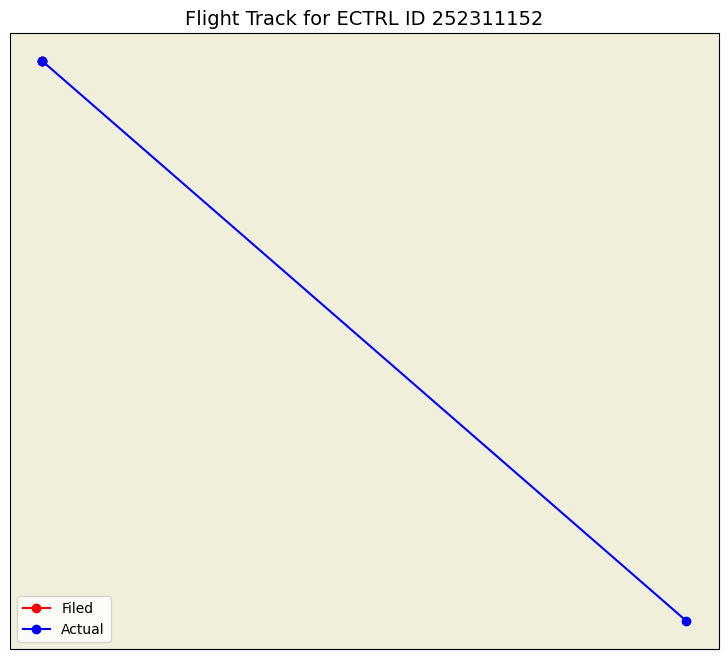

In [ ]:
# 3. Kod
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ECTRL_ID = 252311152  # Burayı kendi ID’nizle değiştirin

filed_csv  = "/content/drive/MyDrive/Flight_Datas/Flight_Points_Filed_20220601_20220630.csv"
actual_csv = "/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv"

df_filed  = pd.read_csv(filed_csv)
df_actual = pd.read_csv(actual_csv)

f = df_filed[df_filed['ECTRL ID']==ECTRL_ID].sort_values('Time Over')
a = df_actual[df_actual['ECTRL ID']==ECTRL_ID].sort_values('Time Over')

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.set_title(f"Flight Track for ECTRL ID {ECTRL_ID}", fontsize=14)

ax.plot(f['Longitude'], f['Latitude'], '-o', color='red',
        transform=ccrs.PlateCarree(), label='Filed')
ax.plot(a['Longitude'], a['Latitude'], '-o', color='blue',
        transform=ccrs.PlateCarree(), label='Actual')

ax.legend(loc='lower left')
plt.show()